In [1]:
import monkeypatch
#from utils import *

Skipping monkeypatch for pd.DataFrame.__del__: libc or malloc_trim() not found


In [2]:
#Import all necessary libraries
import glob
import numpy as np

import warnings
warnings.filterwarnings('ignore')
import _pickle as pickle
import pandas as pd

import re
import random
import collections

from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore
import pyLDAvis
import pyLDAvis.gensim_models
#import pyLDAvis.gensim  # bei älteren Versionen
from gensim import corpora, models
import gensim

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from scipy import stats

pyLDAvis.enable_notebook()
random.seed(1234)

from sklearn.metrics.cluster import adjusted_rand_score
pd.options.display.max_columns = None

C:\ProgramData\Anaconda3\envs\TWM\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [3]:
import multiprocessing
import time
import os
import psutil
def usage():
    process = psutil.Process(os.getpid())
    return process.memory_info()[0] / float(2 ** 20)

# 1. Topic Model on CommonCrawl


## 1.1. Loading and Filtering the Data
There are 28 files with ~2500 records each. 

In [4]:
usage()

187.1640625

In [5]:
%%time
def load_result2():
    result = pd.DataFrame()
    for f in glob.glob("../data/CC/*"):
        d = pd.read_parquet(f)
        d = d[(d['Guessed-Language']=='en')]
        d = d[d['Plaintext'].str.contains("niversity")]
        result = pd.concat((result, d.copy()))
        print(usage())
        del d
        print(usage())
    return result


result = load_result2()
#with multiprocessing.Pool(1) as p:
#    result = p.map(load_result, (0,))

431.05859375
431.05859375
493.18359375
493.18359375
722.56640625
722.56640625
969.0625
969.0625
1177.6171875
1177.6171875
1409.859375
1409.859375
1693.8125
1693.8125
1892.4140625
1892.4140625
2322.046875
2322.046875
2553.51953125
2553.51953125
2575.359375
2575.359375
3010.91796875
3010.91796875
3251.55078125
3251.55078125
3469.86328125
3469.86328125
3667.37890625
3667.37890625
3891.75390625
3891.75390625
4107.07421875
4107.07421875
839.99609375
839.99609375
1251.90234375
1251.90234375
1478.859375
1478.859375
1452.07421875
1452.07421875
1834.7734375
1834.7734375
2030.8359375
2030.8359375
2219.86328125
2219.86328125
2416.890625
2416.890625
2652.09765625
2652.09765625
2870.4375
2870.4375
3071.859375
3071.859375
3188.05859375
3188.05859375
Wall time: 29.2 s


In [6]:
print(result.shape)
print(usage())

(2691, 8)
3188.06640625


## 1.2 Constructing the Corpus and Building the Model

In [7]:
#auxiliary function for "straight-forward" natural language preprocessing

def cleanup_text(record):
    text = record['Plaintext']
    # Remove newlines
    text = text.replace(r'\n', ' ')
    words = text.split()

    # Default list of Stopwords
    stopwords_core = ['a', u'about', u'above', u'after', u'again', u'against', u'all', u'am', u'an', u'and', u'any',
                      u'are', u'arent', u'as', u'at',
                      u'be', u'because', u'been', u'before', u'being', u'below', u'between', u'both', u'but', u'by',
                      u'can', 'cant', 'come', u'could', 'couldnt',
                      u'd', u'did', u'didn', u'do', u'does', u'doesnt', u'doing', u'dont', u'down', u'during',
                      u'each',
                      u'few', 'finally', u'for', u'from', u'further',
                      u'had', u'hadnt', u'has', u'hasnt', u'have', u'havent', u'having', u'he', u'her', u'here',
                      u'hers', u'herself', u'him', u'himself', u'his', u'how',
                      u'i', u'if', u'in', u'into', u'is', u'isnt', u'it', u'its', u'itself',
                      u'just',
                      u'll',
                      u'm', u'me', u'might', u'more', u'most', u'must', u'my', u'myself',
                      u'no', u'nor', u'not', u'now',
                      u'o', u'of', u'off', u'on', u'once', u'only', u'or', u'other', u'our', u'ours', u'ourselves',
                      u'out', u'over', u'own',
                      u'r', u're',
                      u's', 'said', u'same', u'she', u'should', u'shouldnt', u'so', u'some', u'such',
                      u't', u'than', u'that', 'thats', u'the', u'their', u'theirs', u'them', u'themselves', u'then',
                      u'there', u'these', u'they', u'this', u'those', u'through', u'to', u'too',
                      u'under', u'until', u'up',
                      u'very',
                      u'was', u'wasnt', u'we', u'were', u'werent', u'what', u'when', u'where', u'which', u'while',
                      u'who', u'whom', u'why', u'will', u'with', u'wont', u'would',
                      u'y', u'you', u'your', u'yours', u'yourself', u'yourselves']

    # Custom List of Stopwords - Add your own here
    stopwords_custom = ['']
    stopwords = stopwords_core + stopwords_custom
    stopwords = [word.lower() for word in stopwords]

    text_out = [re.sub('[^a-zA-Z0-9]', '', word) for word in words]  # Remove special characters
    text_out = [word.lower() for word in text_out if
                len(word) > 2 and word.lower() not in stopwords]  # Remove stopwords and words under X length
    return text_out


In [8]:
%%time
#build gensim corpus

result=result.reset_index()
texts=[]
for index, row in result.iterrows():
    texts.append(cleanup_text(row))

dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=10, no_above=0.4)
dictionary.compactify()
corpus = [dictionary.doc2bow(text) for text in texts]

Wall time: 26.2 s


In [9]:
usage()

1508.7578125

In [70]:
%%time
ldamodelnormal = gensim.models.ldamodel.LdaModel(corpus, 
                                                 num_topics=15, 
                                                 id2word = dictionary, 
                                                 passes=10, 
                                                 chunksize=100, 
                                                 update_every=0, 
                                                 alpha=1/15, 
                                                 random_state=1)

Wall time: 57.2 s


In [71]:
usage()

1660.1328125

## 1.3 Inspecting the Results

In [72]:
# helper to create descriptive tables (doc-topic probabilities) and visualizations for LDA models 
def getModelResults(ldamodel, corpus, dictionary):
    vis = pyLDAvis.gensim_models.prepare(ldamodel,corpus, dictionary, sort_topics=False)
    transformed = ldamodel.get_document_topics(corpus)
    df = pd.DataFrame.from_records([{v:k for v, k in row} for row in transformed])
    return vis, df    

In [73]:
# get the top topic per document into a list
def maxTop(x):
    mx = max(x,key=lambda item:item[1])
    if (mx[1]>0.0):
        return(mx[0])
    else:
        return 99

In [74]:
%%time
# get descriptive stuff for all models
normalv, dfnormal = getModelResults(ldamodelnormal, corpus, dictionary)


Wall time: 9.78 s


In [75]:
#print regular topics (top word probabilities)
ldamodelnormal.print_topics(num_words=8)

[(0,
  '0.005*"source" + 0.005*"research" + 0.005*"data" + 0.004*"care" + 0.004*"college" + 0.004*"authors" + 0.004*"presentation" + 0.004*"journal"'),
 (1,
  '0.015*"download" + 0.005*"thin" + 0.004*"films" + 0.004*"magnetic" + 0.003*"research" + 0.003*"book" + 0.003*"film" + 0.003*"international"'),
 (2,
  '0.009*"june" + 0.009*"july" + 0.009*"2017" + 0.007*"february" + 0.007*"january" + 0.007*"march" + 0.007*"october" + 0.007*"september"'),
 (3,
  '0.004*"people" + 0.003*"business" + 0.003*"best" + 0.003*"life" + 0.002*"free" + 0.002*"make" + 0.002*"day" + 0.002*"back"'),
 (4,
  '0.010*"school" + 0.010*"college" + 0.008*"ago" + 0.005*"state" + 0.004*"high" + 0.004*"elementary" + 0.004*"years" + 0.003*"day"'),
 (5,
  '0.003*"free" + 0.003*"design" + 0.003*"data" + 0.002*"share" + 0.002*"2017" + 0.002*"years" + 0.002*"dad" + 0.002*"download"'),
 (6,
  '0.036*"architects" + 0.012*"health" + 0.009*"public" + 0.007*"name" + 0.006*"english" + 0.004*"form" + 0.004*"board" + 0.003*"city"'),

C:\ProgramData\Anaconda3\envs\TWM\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\ProgramData\Anaconda3\envs\TWM\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
C:\ProgramData\Anaconda3\envs\TWM\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\ProgramData\Anaconda3\envs\TWM\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_s

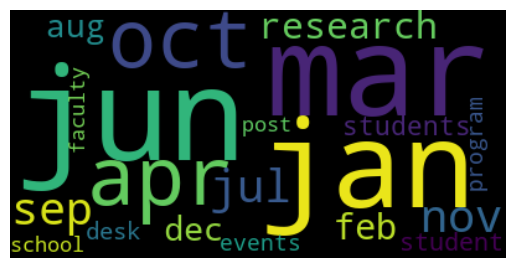

Adult Topic Id = 10


In [76]:
# create a wordcloud for topic: adult content


# get the top topic for a known adult content document 
docTopTopics = [maxTop(x) for x in ldamodelnormal.get_document_topics(corpus)]
adultTopicId = docTopTopics[1]


#gather most relevant terms for the given topic
topics_terms = ldamodelnormal.state.get_lambda()
tmpDict = {}
for i in range(1, len(topics_terms[0])):
    tmpDict[ldamodelnormal.id2word[i]]=topics_terms[adultTopicId,i]


# draw the wordcloud
wordcloud = WordCloud( margin=0,max_words=20 ).generate_from_frequencies(tmpDict)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()
print("Adult Topic Id = " + str(adultTopicId))

In [77]:
# inspect regular topics - ATTENTION: ALL TOPICS ARE SHIFTED WITH ID +1 w.r.t. GENSIM
normalv

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.022398 -0.057066  1       1        4.093084 
1      0.062898  0.003101  2       1        8.271935 
2     -0.038283  0.027316  3       1        7.652424 
3     -0.037484  0.035703  4       1        13.628290
4     -0.083630 -0.021533  5       1        8.952365 
5      0.014266 -0.005649  6       1        2.926635 
6     -0.010159  0.040610  7       1        3.928375 
7     -0.024618  0.022242  8       1        3.311663 
8     -0.034278  0.025832  9       1        4.041342 
9      0.153347  0.015513  10      1        14.698816
10    -0.024196 -0.086516  11      1        5.715770 
11     0.087728  0.018147  12      1        4.187238 
12    -0.057951  0.059306  13      1        5.664571 
13    -0.017450  0.000847  14      1        10.992954
14    -0.012587 -0.077854  15      1        1.934539 , topic_info=             Term         Freq        Total Category  logprob  loglift
11676  architects  5185.000000  5185.000000  Default  30.0000  30.0000
10371  temp        3828.000000  3828.000000  Default  29.0000  29.0000
9200   max         2300.000000  2300.000000  Default  28.0000  28.0000
528    min         2281.000000  2281.000000  Default  27.0000  27.0000
281    download    6012.000000  6012.000000  Default  26.0000  26.0000
...         ...            ...          ...      ...      ...      ...
1526   care        159.031449   3200.540683  Topic15 -5.9732   0.9433 
1209   floor       102.817209   500.858430   Topic15 -6.4093   2.3619 
1792   million     111.776370   1085.346875  Topic15 -6.3258   1.6721 
875    view        122.748386   4462.503148  Topic15 -6.2322   0.3520 
849    two         114.761954   4218.277071  Topic15 -6.2994   0.3410 

[1153 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
12427  1      0.010907  039 
12427  2      0.643514  039 
12427  3      0.010907  039 
12427  4      0.032721  039 
12427  5      0.010907  039 
...   ..           ...  ... 
2044   11     0.030291  york
2044   12     0.012039  york
2044   13     0.067183  york
2044   14     0.055921  york
2044   15     0.020194  york

[12165 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

# OWN CODE

## Praktikum 4 – Teil I: Topic Modell Parameter und Interpretation (Common Crawl)

### 1. Schauen Sie sich die Topic-Wortverteilungen des erstellten Modells an (in Textform, der interaktiven Ausgabe, oder als Wordcloud). Für welche Topics können Sie intuitiv Überbegriffe bilden? Notieren Sie sich diese bzw. legen Sie eine entsprechende „lookup-tabelle“ als Datenstruktur an. Welche Topics erscheinen sinnvoll, welche nicht?

In [ ]:
topics_titles = {0: "medical research", 1: "media piracy", 2: "blogging", 3: "self help / DIY", 4: "education (CORRECTION: college sports teams)", 5: "design", 6: "architecture", 7: "adult", 8: "geography", 9: "politics", 10: "university?", 11: "technology", 12: "art", 13: "education", 14: "weather / climate"}

topics_terms = ldamodelnormal.state.get_lambda()
for topic_id in range(len(topics_terms)):
    tmpDict = {}
    for i in range(1, len(topics_terms[topic_id])):
        tmpDict[ldamodelnormal.id2word[i]]=topics_terms[topic_id,i]

    # draw the wordcloud
    wordcloud = WordCloud( margin=0,max_words=20 ).generate_from_frequencies(tmpDict)
    plt.title(f"{topic_id}: {topics_titles[topic_id]}")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()

### 2. Notieren Sie sich, welches Topic im 5. Codeblock unter Abschnitt als „adult content“ identifiziert wurde. Filtern Sie für die weiteren Aufgaben die entsprechenden Records aus dem „result“ DataFrame aus, also z.B. alle Dokumente mit einer entsprechenden Topicwahrscheinlichkeit > 50%. Öffnen Sie nicht die Links zu den entsprechenden Dokumenten im Browser. Aktivieren Sie sicherheitshalber den installierten Browser-Filter.

In [ ]:
censored_result = result[(dfnormal[7] <= 0.5) | (dfnormal[7].isna())]
censored_dfnormal = dfnormal[(dfnormal[7] <= 0.5) | (dfnormal[7].isna())]

#inspect first 20 documents and their topic distributions
pd.set_option('display.max_colwidth', -1)
pd.concat([censored_result['Target-URI'], censored_dfnormal], axis=1).iloc[0:20]

### 3. Schauen Sie sich nun für einige andere Topics stichprobenartig Dokumente an. Passen diese zu den vorher von Ihnen vergebenen Topic-Überbegriffen? Warum bzw. warum nicht?

In [96]:
for k, v in topics_titles.items():
    print(k, v)

0 medical research
1 media piracy
2 blogging
3 self help / DIY
4 education (CORRECTION: college sports teams)
5 design
6 architecture
7 adult
8 geography
9 politics
10 university?
11 technology
12 art
13 education
14 weather / climate


In [93]:
query_result, _ = get_by_topic(censored_result, censored_dfnormal, [4], [0.7])
pd.concat([query_result['Target-URI']], axis=1).iloc[0:10]

,Target-URI
14,http://lmmc.ca/en/concert_details.php?concert_id=114
21,https://www.620ckrm.com/2017/03/11/regina-cougars-wbb-team-to-play-in-usports-canada-consolation-final/
24,http://feathermerchant.com/?category=sports%3Ecollege&id=363&type=golf%20towel
46,https://www.thestudentroom.co.uk/showthread.php?t=5012052
52,http://ginasbluewaterbabies.com.au/category/uncategorized/page/2/
56,http://gamestrailer.info/universities-in-newcastle-upon-tyne/
62,https://www.delgazette.com/wire/state-wire/55244/ohio-student-athlete-badly-hurt-in-makeshift-pool-at-party
112,http://osuvetjobs.org/jobs/10946747/experienced-vet-tech-needed-in-busy-4-doctor-practice
124,https://www.roero-illuminazione.it/cms/community/social/immagini/foto-community.html
174,http://www.kofc.org/en/columbia/detail/2012_08_legacy.html


### 4. Formulieren Sie Anfragen zu bestimmten Topic-Mischungen (z.B. Topic A > 40% und Topic B > 40%). Passen die gematchten Dokumente zu Ihren Erwartungen? Warum bzw. warum nicht?

In [69]:
def get_by_topic(result, dfnormal, topics, percentages):
    """
    topics: [topic1, topic2, ..]
    percentages: [0.5, 0.5, ..]
    """
    for i, topic_no in enumerate(topics):
        result = result[(dfnormal[topic_no] > percentages[i])]
        dfnormal = dfnormal[(dfnormal[topic_no] > percentages[i])]
    return result, dfnormal

In [97]:
for k, v in topics_titles.items():
    print(k, v)

0 medical research
1 media piracy
2 blogging
3 self help / DIY
4 education (CORRECTION: college sports teams)
5 design
6 architecture
7 adult
8 geography
9 politics
10 university?
11 technology
12 art
13 education
14 weather / climate


In [105]:
query_result, _ = get_by_topic(censored_result, censored_dfnormal, [2, 4], [0.4, 0.4])
pd.concat([query_result['Target-URI']], axis=1).iloc[0:10]

,Target-URI
87,https://nevadacycling.wordpress.com/2012/09/
245,https://navarrepress.com/tag/races/
292,http://thepipelineshow.blogspot.com/2012/04/whl-dominates-chl-attendance-numbers.html
663,http://southfloridasport.blogspot.com/2016/02/miami-ratings-january-2016.html
754,https://postinspostcards.com/2015/12/02/cfa-2015-game-103-cincinnati-at-usf-nov-20/
1670,http://photos.gardner-webb.edu/2016-Photos/December-2016/Shanghai-Faculty-Visit/i-gKr3BXd/
1681,http://unitykhartoum.blogspot.com/2014/09/an-exchange-of-emails-between-dr-marina.html
2011,https://buifc.wordpress.com/upcoming-events/
2095,http://eagles-rju.blogspot.com/2018/06/four-ncaa-skaters-among-first-14-taken.html
2422,http://eagles-rju.blogspot.com/2015/09/


sports blogs

### 5. Berechnen Sie zwei neue Modelle (auf dem Original-Corpus mit Adult-Content) mit verändertem Glättungsparameter für die Dokument-Topic Zuordnungen. Die restlichen Parameter sollen beibehalten werden. Berechnen Sie ein Modell mit Glättungsparameter=1 und ein Modell mit Glättungsparameter=10^-18. Wie sollte sich das Modell Ihrer Erwartung nach verändern? Schauen Sie sich wieder jeweils die ersten 20 Zeilen der Dokument-Topic Wahrscheinlichkeitsmatrizen an. Plotten Sie weiterhin die Häufigkeitsverteilungen der „Nicht-NaN-Topics“ pro Dokument. Was fällt Ihnen auf? Entspricht dies Ihren Erwartungen?

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

#### alpha = 10e-18

In [27]:
#inspect first 20 documents and their topic distributions
pd.set_option('display.max_colwidth', -1)
pd.concat([result['Target-URI'], dfnormal], axis=1).iloc[0:20]

,Target-URI,9,0,4,10,13,7,2,5,1,3,11,8,14,12,6
0,https://www.spiedigitallibrary.org/journals/journal-of-biomedical-optics/volume-22/issue-02/027003/Enzyme-functionalized-thin-cladding-long-period-fiber-grating-in-transition/10.1117/1.JBO.22.2.027003.full,0.998748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://redcliffssecondarycareers.com/?page=early-entry,NaN,0.263662,0.032040,0.383010,0.321288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://www.kink.com/shoot/40316,NaN,NaN,NaN,0.110866,NaN,0.889134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,http://ducknetweb.blogspot.com/2014/09/aarp-creates-new-tablet-for-seniors.html,0.050644,NaN,NaN,NaN,0.102955,NaN,0.829827,0.011819,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://www.umassmed.edu/cttc/,0.319294,NaN,NaN,NaN,0.679428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,https://ju.se/en/it-helpdesk/faq---manuals.html,NaN,NaN,NaN,0.551079,NaN,NaN,NaN,0.144552,0.304369,NaN,NaN,NaN,NaN,NaN,NaN
6,https://www.jobs.ac.uk/job/AXS985/research-associate-78443-037/,NaN,0.620408,NaN,0.379592,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,http://www.mathdepartment.net/Butte-College-math-department.php,NaN,0.561742,0.438258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,https://collections.ushmm.org/search/catalog/irn1003631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.694127,0.305873,NaN,NaN,NaN,NaN
9,http://mdciedu.com/news/british-masters-in-business-administration-mba-degree-final-applications-being-received-al-khobar-monday-16th-february-2015/,NaN,NaN,0.121561,0.605606,NaN,NaN,0.038029,0.039876,NaN,NaN,NaN,0.188162,NaN,NaN,NaN


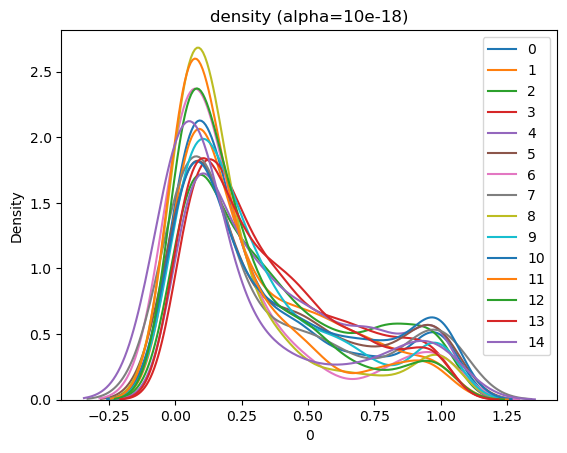

In [69]:
for col in range(15):
    sns.kdeplot(dfnormal[col], label=col)
plt.legend()
plt.title(f"density (alpha=10e-18)")
plt.show()

#### alpha = 1/15

In [36]:
#inspect first 20 documents and their topic distributions
pd.set_option('display.max_colwidth', -1)
pd.concat([result['Target-URI'], dfnormal], axis=1).iloc[0:20]

,Target-URI,9,0,4,10,13,7,2,5,11,1,3,8,12,14,6
0,https://www.spiedigitallibrary.org/journals/journal-of-biomedical-optics/volume-22/issue-02/027003/Enzyme-functionalized-thin-cladding-long-period-fiber-grating-in-transition/10.1117/1.JBO.22.2.027003.full,0.998102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://redcliffssecondarycareers.com/?page=early-entry,NaN,0.288477,0.036899,0.386017,0.286872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://www.kink.com/shoot/40316,NaN,NaN,NaN,0.114021,NaN,0.882783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,http://ducknetweb.blogspot.com/2014/09/aarp-creates-new-tablet-for-seniors.html,0.050195,NaN,NaN,NaN,0.102357,NaN,0.828883,0.011495,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://www.umassmed.edu/cttc/,0.315403,0.021763,NaN,NaN,0.647697,NaN,NaN,NaN,0.013256,NaN,NaN,NaN,NaN,NaN,NaN
5,https://ju.se/en/it-helpdesk/faq---manuals.html,NaN,NaN,NaN,0.550522,NaN,NaN,NaN,0.153661,NaN,0.292651,NaN,NaN,NaN,NaN,NaN
6,https://www.jobs.ac.uk/job/AXS985/research-associate-78443-037/,NaN,0.632492,NaN,0.355289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,http://www.mathdepartment.net/Butte-College-math-department.php,NaN,0.561683,0.437684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,https://collections.ushmm.org/search/catalog/irn1003631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.449614,NaN,0.550334,NaN,NaN,NaN,NaN
9,http://mdciedu.com/news/british-masters-in-business-administration-mba-degree-final-applications-being-received-al-khobar-monday-16th-february-2015/,NaN,NaN,0.124485,0.601398,NaN,NaN,0.040911,0.042650,NaN,NaN,NaN,0.188534,NaN,NaN,NaN


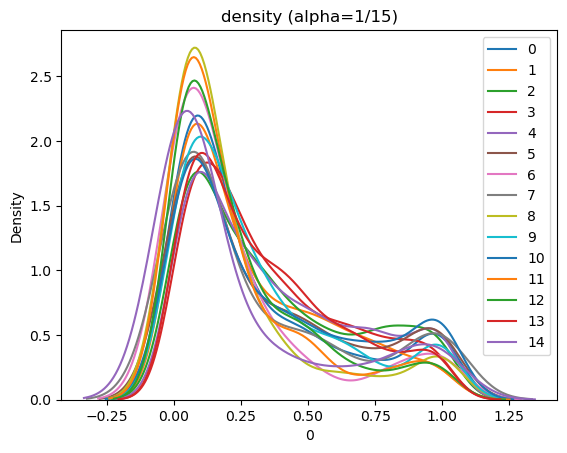

In [51]:
for col in range(15):
    sns.kdeplot(dfnormal[col], label=col)
plt.legend()
plt.title(f"density (alpha=1/15)")
plt.show()

#### alpha = 1

In [18]:
#inspect first 20 documents and their topic distributions
pd.set_option('display.max_colwidth', -1)
pd.concat([result['Target-URI'], dfnormal], axis=1).iloc[0:20]

,Target-URI,9,0,3,4,10,13,2,7,12,6,11,1,5,8,14
0,https://www.spiedigitallibrary.org/journals/journal-of-biomedical-optics/volume-22/issue-02/027003/Enzyme-functionalized-thin-cladding-long-period-fiber-grating-in-transition/10.1117/1.JBO.22.2.027003.full,0.978410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://redcliffssecondarycareers.com/?page=early-entry,0.011255,0.612483,0.011433,0.039805,0.231091,0.037204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://www.kink.com/shoot/40316,NaN,NaN,NaN,0.071779,0.134603,NaN,0.027065,0.717689,0.010009,NaN,NaN,NaN,NaN,NaN,NaN
3,http://ducknetweb.blogspot.com/2014/09/aarp-creates-new-tablet-for-seniors.html,0.031705,NaN,0.038273,NaN,NaN,0.080650,0.812806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://www.umassmed.edu/cttc/,0.273894,0.273123,NaN,0.019941,0.011843,0.105309,NaN,0.015907,NaN,0.014532,0.244002,NaN,NaN,NaN,NaN
5,https://ju.se/en/it-helpdesk/faq---manuals.html,NaN,0.520718,NaN,0.011138,0.232887,NaN,0.010856,NaN,NaN,NaN,0.010975,0.058225,0.091201,0.014582,NaN
6,https://www.jobs.ac.uk/job/AXS985/research-associate-78443-037/,0.016071,0.667599,0.024829,0.021267,0.060150,0.020380,0.022043,0.019875,0.017128,0.020550,0.017644,0.021662,0.021437,0.031905,0.017460
7,http://www.mathdepartment.net/Butte-College-math-department.php,NaN,0.664687,NaN,0.313374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,https://collections.ushmm.org/search/catalog/irn1003631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.997159,NaN,NaN,NaN,NaN
9,http://mdciedu.com/news/british-masters-in-business-administration-mba-degree-final-applications-being-received-al-khobar-monday-16th-february-2015/,NaN,0.275682,0.011091,0.074377,0.339584,0.019989,0.043015,NaN,NaN,NaN,NaN,0.013072,0.015649,0.170254,NaN


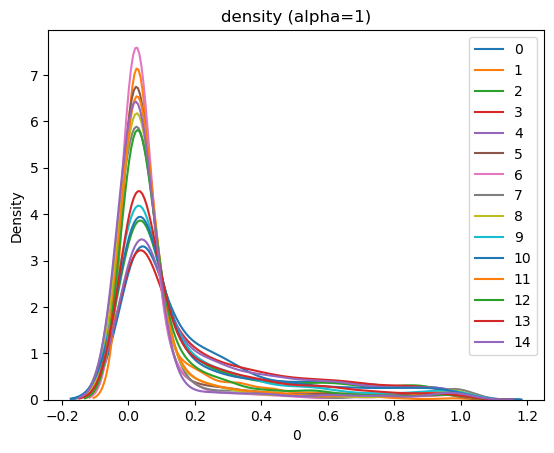

In [60]:
for col in range(15):
    sns.kdeplot(dfnormal[col], label=col)
plt.legend()
plt.title(f"density (alpha=1)")
plt.show()

## Praktikum 4 – Teil II: Topic Modell auf eigenen gecrawlten Texten

In [116]:
def my_cleanup_text(text):
    # Remove newlines
    text = text.replace(r'\n', ' ')
    words = text.split()

    # Default list of Stopwords
    stopwords_core = ['a', u'about', u'above', u'after', u'again', u'against', u'all', u'am', u'an', u'and', u'any',
                      u'are', u'arent', u'as', u'at',
                      u'be', u'because', u'been', u'before', u'being', u'below', u'between', u'both', u'but', u'by',
                      u'can', 'cant', 'come', u'could', 'couldnt',
                      u'd', u'did', u'didn', u'do', u'does', u'doesnt', u'doing', u'dont', u'down', u'during',
                      u'each',
                      u'few', 'finally', u'for', u'from', u'further',
                      u'had', u'hadnt', u'has', u'hasnt', u'have', u'havent', u'having', u'he', u'her', u'here',
                      u'hers', u'herself', u'him', u'himself', u'his', u'how',
                      u'i', u'if', u'in', u'into', u'is', u'isnt', u'it', u'its', u'itself',
                      u'just',
                      u'll',
                      u'm', u'me', u'might', u'more', u'most', u'must', u'my', u'myself',
                      u'no', u'nor', u'not', u'now',
                      u'o', u'of', u'off', u'on', u'once', u'only', u'or', u'other', u'our', u'ours', u'ourselves',
                      u'out', u'over', u'own',
                      u'r', u're',
                      u's', 'said', u'same', u'she', u'should', u'shouldnt', u'so', u'some', u'such',
                      u't', u'than', u'that', 'thats', u'the', u'their', u'theirs', u'them', u'themselves', u'then',
                      u'there', u'these', u'they', u'this', u'those', u'through', u'to', u'too',
                      u'under', u'until', u'up',
                      u'very',
                      u'was', u'wasnt', u'we', u'were', u'werent', u'what', u'when', u'where', u'which', u'while',
                      u'who', u'whom', u'why', u'will', u'with', u'wont', u'would',
                      u'y', u'you', u'your', u'yours', u'yourself', u'yourselves']

    # Custom List of Stopwords - Add your own here
    stopwords_custom = ['']
    stopwords = stopwords_core + stopwords_custom
    stopwords = [word.lower() for word in stopwords]

    text_out = [re.sub('[^a-zA-Z0-9]', '', word) for word in words]  # Remove special characters
    text_out = [word.lower() for word in text_out if len(word) > 2 and word.lower() not in stopwords]  # Remove stopwords and words under X length
    return text_out

In [117]:
grappling_data = pd.read_csv(os.path.join("..", "data", "GrapplingInsider.csv"))
grappling_data.text = grappling_data.text.apply(my_cleanup_text)
grappling_dictionary = corpora.Dictionary(grappling_data.text)
grappling_dictionary.filter_extremes(no_below=10, no_above=0.4)
grappling_dictionary.compactify()
grappling_corpus = [grappling_dictionary.doc2bow(text) for text in grappling_data.text]

In [135]:
grappling_ldamodelnormal = gensim.models.ldamodel.LdaModel(grappling_corpus, 
                                                 num_topics=6, 
                                                 id2word = grappling_dictionary, 
                                                 passes=10, 
                                                 chunksize=100, 
                                                 update_every=0, 
                                                 alpha=1/15, 
                                                 random_state=1)

In [136]:
# get descriptive stuff for all models
grappling_normalv, grappling_dfnormal = getModelResults(grappling_ldamodelnormal, grappling_corpus, grappling_dictionary)

In [124]:
grappling_normalv

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.000068  0.045963  1       1        9.517353 
1      0.081021 -0.061210  2       1        15.298650
2      0.082572  0.088869  3       1        14.893820
3      0.020938 -0.071014  4       1        15.762987
4     -0.131077  0.013231  5       1        31.757316
5     -0.053387 -0.015838  6       1        12.769873, topic_info=             Term         Freq        Total Category  logprob  loglift
597   via          1445.000000  1445.000000  Default  30.0000  30.0000
1473  defeats      631.000000   631.000000   Default  29.0000  29.0000
1280  def          908.000000   908.000000   Default  28.0000  28.0000
391   ufc          1091.000000  1091.000000  Default  27.0000  27.0000
39    guard        1318.000000  1318.000000  Default  26.0000  26.0000
...     ...                ...          ...      ...      ...      ...
621   competitors  94.531789    775.007480   Topic6  -5.8886  -0.0459 
183   nogi         93.621456    1051.761798  Topic6  -5.8983  -0.3609 
117   way          90.700618    618.162782   Topic6  -5.9300   0.1389 
123   2019         89.735023    582.393671   Topic6  -5.9407   0.1878 
477   get          89.800294    1035.747722  Topic6  -5.9400  -0.3872 

[478 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
600   1      0.025319  15minute
600   2      0.202550  15minute
600   3      0.025319  15minute
600   4      0.683605  15minute
600   5      0.075956  15minute
...  ..           ...       ...
912   2      0.015259  youve   
912   3      0.015259  youve   
912   4      0.015259  youve   
912   5      0.839236  youve   
912   6      0.076294  youve   

[2006 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6])

### 1. Schauen Sie sich die Topic-Wortverteilungen des erstellten Modells an (in Textform, der interaktiven Ausgabe, oder als Wordcloud). Für welche Topics können Sie intuitiv Überbegriffe bilden? Notieren Sie sich diese bzw. legen Sie eine entsprechende „lookup-tabelle“ als Datenstruktur an. Welche Topics erscheinen sinnvoll, welche nicht?

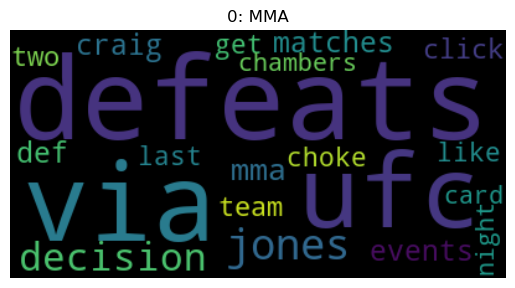

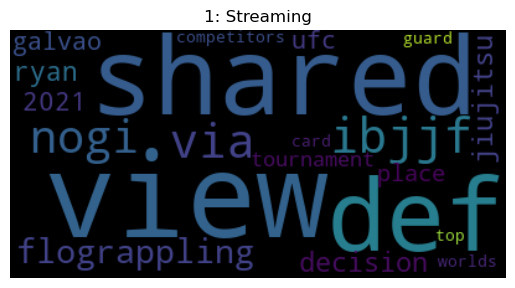

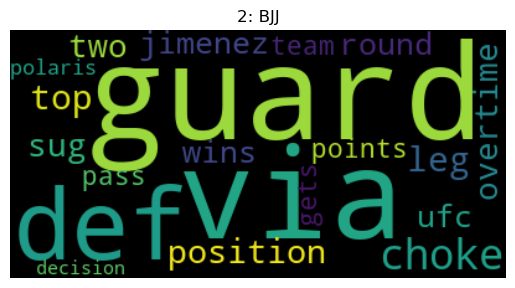

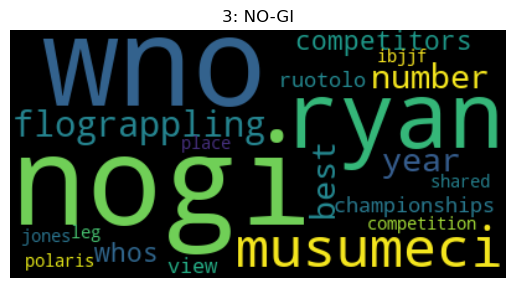

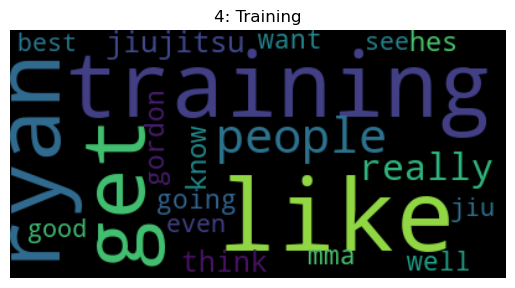

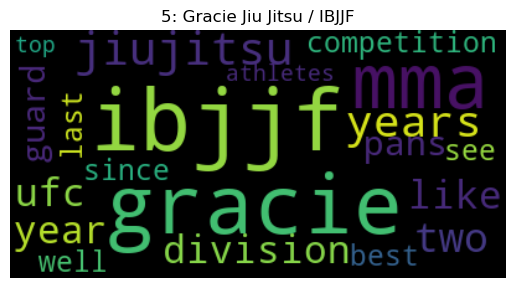

In [184]:
grappling_topics_titles = {0: "MMA", 1: "Streaming", 2: "BJJ", 3: "NO-GI", 4: "Training", 5: "Gracie Jiu Jitsu / IBJJF"}

grappling_topics_terms = grappling_ldamodelnormal.state.get_lambda()
for topic_id in range(len(grappling_topics_terms)):
    tmpDict = {}
    for i in range(1, len(grappling_topics_terms[topic_id])):
        tmpDict[grappling_ldamodelnormal.id2word[i]]=grappling_topics_terms[topic_id,i]

    # draw the wordcloud
    wordcloud = WordCloud( margin=0,max_words=20 ).generate_from_frequencies(tmpDict)
    plt.title(f"{topic_id}: {grappling_topics_titles[topic_id]}")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()

### 2. Notieren Sie sich, welches Topic im 5. Codeblock unter Abschnitt als „adult content“ identifiziert wurde. Filtern Sie für die weiteren Aufgaben die entsprechenden Records aus dem „result“ DataFrame aus, also z.B. alle Dokumente mit einer entsprechenden Topicwahrscheinlichkeit > 50%. Öffnen Sie nicht die Links zu den entsprechenden Dokumenten im Browser. Aktivieren Sie sicherheitshalber den installierten Browser-Filter.

does not apply

### 3. Schauen Sie sich nun für einige andere Topics stichprobenartig Dokumente an. Passen diese zu den vorher von Ihnen vergebenen Topic-Überbegriffen? Warum bzw. warum nicht?

In [185]:
for k, v in grappling_topics_titles.items():
    print(k, v)

0 MMA
1 Streaming
2 BJJ
3 NO-GI
4 Training
5 Gracie Jiu Jitsu / IBJJF


In [192]:
for cat_id, cat in grappling_topics_titles.items():
    query_result, _ = get_by_topic(grappling_data, grappling_dfnormal, [cat_id], [0.5])
    print(cat_id, cat)
    print(query_result.title[:10])
    print()

0 MMA
23     Video: On closer look, Aljamain Sterling appears to tap to Damien Nitkin at High Rollerz 18
52     Who’s Next episode 6 results and recap: The final is set                                   
79     ‘Ready to get famous?’: Who’s Next episode 1 recap and results                             
90     Mike Tyson, Wiz Khalifa, and Nate Diaz sponsor athletes at High Rollerz 15                 
108    FloGrappling’s Who’s Next: Submission Fighter Challenge reality show set for May debut     
233    Chael Sonnen Hints That Submission Underground Will Move to FloGrappling                   
257    Craig Jones Vs. UFC’s Donald ‘Cowboy’ Cerrone In Combat Jiu-Jitsu Worlds 2021              
258    Dillon Danis Ejected From UFC 268, Slapped by Manager Ali Abdelaziz                        
328    High Rollerz: Cops Vs Stonerz – 18 September!                                              
363    Demian Maia Not Ready to Retire Yet, Plans to Compete in Jiu-Jitsu                         
Name

0 MMA: kind of fits, but very hit and miss

1 Streaming: kind of fits the streaming of events

2 BJJ: more like results and highlights

3 NO-GI: fits really well

4 Training: fits really well

5 Gracie Jiu Jitsu / IBJJF: actually more like promotions and controversies

### 4. Formulieren Sie Anfragen zu bestimmten Topic-Mischungen (z.B. Topic A > 40% und Topic B > 40%). Passen die gematchten Dokumente zu Ihren Erwartungen? Warum bzw. warum nicht?

In [194]:
query_result, _ = get_by_topic(grappling_data, grappling_dfnormal, [2, 3], [0.4, 0.4])
print(query_result.title[:10])

5 Gracie Jiu Jitsu / IBJJF
220     Video: Ashley Williams Submits Robert Degle at Grapple Kings 6                  
426     Beyond The Match: Re-live Andrew Wiltse’s Comeback Submission on Gabriel Almeida
525     JT Torres, Edwin Najmi to Represent Team USA at Polaris Squads                  
570     Polaris Squads to Return With Team USA vs. Team UK and Ireland                  
1090    Polaris 12: The Undercard’s Hidden Gems                                         
1127    ADCC 2019 Results: Craig Jones Chokes Out Thor                                  
1139    ADCC 2019 Results: Craig Jones vs Ben Dyson                                     
1357    Ross Nicholls vs. Vagner Rocha set for Polaris 9                                
Name: title, dtype: object


works really well

### 5. Berechnen Sie zwei neue Modelle (auf dem Original-Corpus mit Adult-Content) mit verändertem Glättungsparameter für die Dokument-Topic Zuordnungen. Die restlichen Parameter sollen beibehalten werden. Berechnen Sie ein Modell mit Glättungsparameter=1 und ein Modell mit Glättungsparameter=10^-18. Wie sollte sich das Modell Ihrer Erwartung nach verändern? Schauen Sie sich wieder jeweils die ersten 20 Zeilen der Dokument-Topic Wahrscheinlichkeitsmatrizen an. Plotten Sie weiterhin die Häufigkeitsverteilungen der „Nicht-NaN-Topics“ pro Dokument. Was fällt Ihnen auf? Entspricht dies Ihren Erwartungen?

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

#### alpha = 10e-18

In [133]:
#inspect first 20 documents and their topic distributions
pd.set_option('display.max_colwidth', -1)
pd.concat([grappling_data['url'], grappling_dfnormal], axis=1).iloc[0:20]

,url,4,5,1,2,3,0
0,https://grapplinginsider.com/like-mother-like-son-how-rodrigo-marellos-mom-taught-him-jiu-jitsu-and-more/,0.679708,0.320292,NaN,NaN,NaN,NaN
1,https://grapplinginsider.com/gordon-ryan-insists-on-no-time-limit-stipulation-in-fourth-felipe-pena-match/,0.105233,NaN,0.894767,NaN,NaN,NaN
2,https://grapplinginsider.com/mikey-musumeci-beats-cleber-sousa-to-capture-first-ever-one-submission-grappling-world-title/,NaN,0.112015,0.221639,0.062616,0.603731,NaN
3,https://grapplinginsider.com/ufc-champ-leon-edwards-awarded-bjj-black-belt/,NaN,0.799338,NaN,NaN,NaN,0.200662
4,https://grapplinginsider.com/nick-rodriguez-giancarlo-bodoni-and-others-set-for-a-stacked-ebi-20/,NaN,NaN,NaN,NaN,1.000000,NaN
5,https://grapplinginsider.com/mikey-musumeci-wants-grappling-match-against-demetrious-johnson/,0.079478,0.593788,NaN,NaN,0.326734,NaN
6,https://grapplinginsider.com/nathalia-santoro-bjj-brown-belt/,1.000000,NaN,NaN,NaN,NaN,NaN
7,https://grapplinginsider.com/match-preview-mikey-musumeci-vs-cleber-sousa-for-first-ever-one-submission-grappling-championship/,NaN,0.036851,NaN,0.157913,0.805236,NaN
8,https://grapplinginsider.com/video-watch-rodrigo-marellos-record-setting-50000-foot-lock/,NaN,0.713223,NaN,0.096388,0.190388,NaN
9,https://grapplinginsider.com/competition-tips-for-bjj-beginners-with-emily-eyles/,1.000000,NaN,NaN,NaN,NaN,NaN


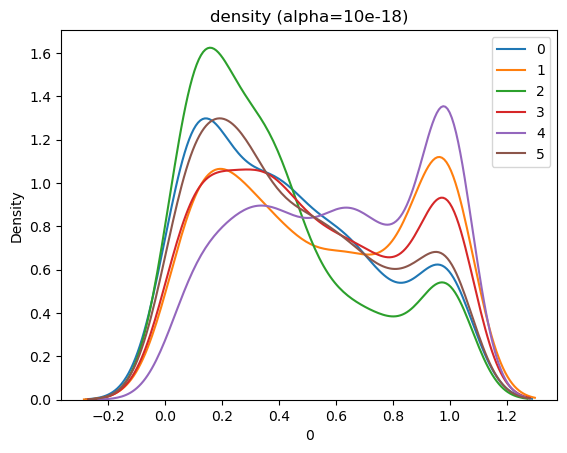

In [134]:
for col in range(6):
    sns.kdeplot(grappling_dfnormal[col], label=col)
plt.legend()
plt.title(f"density (alpha=10e-18)")
plt.show()

#### alpha = 1/15

In [137]:
#inspect first 20 documents and their topic distributions
pd.set_option('display.max_colwidth', -1)
pd.concat([grappling_data['url'], grappling_dfnormal], axis=1).iloc[0:20]

,url,4,5,1,2,3,0
0,https://grapplinginsider.com/like-mother-like-son-how-rodrigo-marellos-mom-taught-him-jiu-jitsu-and-more/,0.700386,0.298001,NaN,NaN,NaN,NaN
1,https://grapplinginsider.com/gordon-ryan-insists-on-no-time-limit-stipulation-in-fourth-felipe-pena-match/,0.107460,NaN,0.890626,NaN,NaN,NaN
2,https://grapplinginsider.com/mikey-musumeci-beats-cleber-sousa-to-capture-first-ever-one-submission-grappling-world-title/,NaN,0.104143,0.211201,0.069771,0.613956,NaN
3,https://grapplinginsider.com/ufc-champ-leon-edwards-awarded-bjj-black-belt/,NaN,0.798015,NaN,NaN,NaN,0.200211
4,https://grapplinginsider.com/nick-rodriguez-giancarlo-bodoni-and-others-set-for-a-stacked-ebi-20/,NaN,NaN,NaN,NaN,0.997383,NaN
5,https://grapplinginsider.com/mikey-musumeci-wants-grappling-match-against-demetrious-johnson/,0.096474,0.565981,NaN,NaN,0.336257,NaN
6,https://grapplinginsider.com/nathalia-santoro-bjj-brown-belt/,0.998182,NaN,NaN,NaN,NaN,NaN
7,https://grapplinginsider.com/match-preview-mikey-musumeci-vs-cleber-sousa-for-first-ever-one-submission-grappling-championship/,NaN,0.035816,NaN,0.158494,0.805188,NaN
8,https://grapplinginsider.com/video-watch-rodrigo-marellos-record-setting-50000-foot-lock/,NaN,0.695009,NaN,0.101038,0.202156,NaN
9,https://grapplinginsider.com/competition-tips-for-bjj-beginners-with-emily-eyles/,0.999370,NaN,NaN,NaN,NaN,NaN


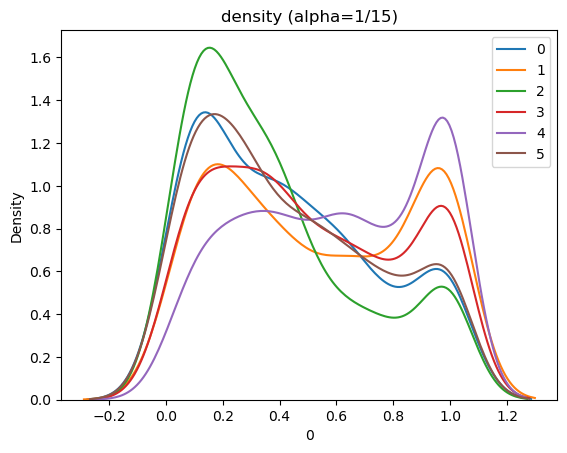

In [138]:
for col in range(6):
    sns.kdeplot(grappling_dfnormal[col], label=col)
plt.legend()
plt.title(f"density (alpha=1/15)")
plt.show()

#### alpha = 1

In [120]:
#inspect first 20 documents and their topic distributions
pd.set_option('display.max_colwidth', -1)
pd.concat([grappling_data['url'], grappling_dfnormal], axis=1).iloc[0:20]

,url,1,2,3,4,5,0
0,https://grapplinginsider.com/like-mother-like-son-how-rodrigo-marellos-mom-taught-him-jiu-jitsu-and-more/,0.033490,0.010093,0.014396,0.860197,0.072231,NaN
1,https://grapplinginsider.com/gordon-ryan-insists-on-no-time-limit-stipulation-in-fourth-felipe-pena-match/,0.677494,0.010137,0.177087,0.093382,0.027593,0.014307
2,https://grapplinginsider.com/mikey-musumeci-beats-cleber-sousa-to-capture-first-ever-one-submission-grappling-world-title/,0.199850,0.070419,0.559891,0.030673,0.112537,0.026631
3,https://grapplinginsider.com/ufc-champ-leon-edwards-awarded-bjj-black-belt/,0.073046,0.018893,0.020384,0.227518,0.343068,0.317091
4,https://grapplinginsider.com/nick-rodriguez-giancarlo-bodoni-and-others-set-for-a-stacked-ebi-20/,0.101922,0.022763,0.830459,0.012022,0.012761,0.020072
5,https://grapplinginsider.com/mikey-musumeci-wants-grappling-match-against-demetrious-johnson/,0.020887,0.012737,0.542207,0.330434,0.071963,0.021772
6,https://grapplinginsider.com/nathalia-santoro-bjj-brown-belt/,0.021213,0.010166,0.034501,0.890159,0.021602,0.022359
7,https://grapplinginsider.com/match-preview-mikey-musumeci-vs-cleber-sousa-for-first-ever-one-submission-grappling-championship/,0.038044,0.126510,0.745837,0.011795,0.070815,NaN
8,https://grapplinginsider.com/video-watch-rodrigo-marellos-record-setting-50000-foot-lock/,0.036171,0.087252,0.354492,0.215140,0.259258,0.047688
9,https://grapplinginsider.com/competition-tips-for-bjj-beginners-with-emily-eyles/,NaN,NaN,NaN,0.982495,NaN,NaN


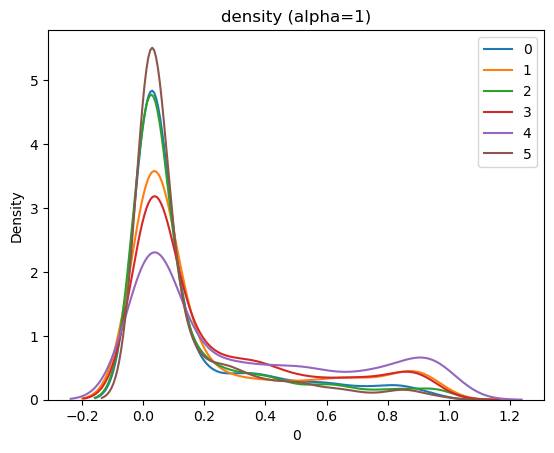

In [130]:
for col in range(6):
    sns.kdeplot(grappling_dfnormal[col], label=col)
plt.legend()
plt.title(f"density (alpha=1)")
plt.show()